In [39]:
import tensorflow as tf
import os

def extract_genus_and_species(path):
    # Extract the folder name from the full path
    folder_name = os.path.basename(os.path.dirname(path))
    
    # Split the folder name assuming the format "family_genus_species"
    _, genus, species = folder_name.split('_')
    
    return genus, species

def get_label_index(labels_list, label):
    # Get the index of the label from the labels_list
    return labels_list.index(label)

def custom_label_function(path, genus_labels, species_labels):
    # Extract genus and species
    genus, species = extract_genus_and_species(path)
    
    # Convert genus and species to indices
    genus_index = get_label_index(genus_labels, genus)
    species_index = get_label_index(species_labels, species)
    
    return genus_index, species_index

def process_path(path, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)
    
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])
    
    # Get the genus and species labels
    genus_label, species_label = custom_label_function(path, genus_labels, species_labels)
    
    # Convert to one-hot encoded format
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))
    
    return img, {"genus": genus_label, "species": species_label}


In [41]:
import tensorflow as tf
import os

def extract_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[-2]  # Assumes the structure '/.../family_genus_species/image.jpg'
    
    # Split the folder name assuming the format "family_genus_species"
    genus_and_species = tf.strings.split(folder_name, '_')
    genus = genus_and_species[-2]
    species = genus_and_species[-2] + " " + genus_and_species[-1]
    
    return genus, species

def process_path(path, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)
    
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])
    
    # Get the genus and species labels
    genus, species = extract_genus_and_species_from_path(path)
    
    # Convert genus and species to indices
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))
    
    # Convert to one-hot encoded format
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))
    
    return img, {"genus": genus_label, "species": species_label}

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                
                # Extract genus and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                _, genus, species = folder_name.split('_')
                
                species = genus + ' ' + species
                
                # Collect unique genus and species names
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)
    
    # Convert genus and species labels to TensorFlow tensors
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(lambda x: process_path(x, genus_labels, species_labels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return image_label_ds, genus_labels.numpy().tolist(), species_labels.numpy().tolist()

# Example usage

train_ds, genus_labels, species_labels = build_dataset("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
valid_ds, genus_labels, species_labels = build_dataset("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")
test_ds, genus_labels, species_labels = build_dataset("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Model preprocess
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Data Augmentation Function
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),  # Randomly zoom in on the image
  tf.keras.layers.RandomTranslation(0.1, 0.1),  # Randomly translate the image in horizontal and vertical directions
  tf.keras.layers.RandomContrast(0.2),  # Adjust the contrast of the image
  tf.keras.layers.RandomBrightness(0.2),  # Adjust the brightness of the image
  tf.keras.layers.RandomCrop(224, 224)  # Randomly crop the image to the target size
])

In [46]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2

# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    pooling='avg',
    input_shape=(224, 224, 3)
)

# Non-trainable layers (you can later fine-tune by setting this to True)
base_model.trainable = False

# Inputs
inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augmentation and preprocessing
x = data_augmentation(inputs)  # Assuming data_augmentation is defined elsewhere
x = preprocess_input(x)  # Assuming preprocess_input is defined elsewhere
x = base_model(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)

# Shared dense layer
x_shared = tf.keras.layers.Dense(
    1024,
    activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)
x_shared = tf.keras.layers.BatchNormalization()(x_shared)
x_shared = tf.keras.layers.Dropout(0.2)(x_shared)

# Genus output head
output_genus = tf.keras.layers.Dense(len(genus_labels), activation="softmax", name="genus")(x_shared)

# Species-specific dense layer
x_species = tf.keras.layers.Dense(
    512,  # Additional complexity for species
    activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x_shared)
x_species = tf.keras.layers.BatchNormalization()(x_species)
x_species = tf.keras.layers.Dropout(0.2)(x_species)

# Species output head
output_species = tf.keras.layers.Dense(len(species_labels), activation="softmax", name="species")(x_species)

# Final Model Setup
model = tf.keras.models.Model(inputs=inputs, outputs=[output_genus, output_species])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={"genus": "categorical_crossentropy", "species": "categorical_crossentropy"},
    metrics={"genus": ['accuracy'], "species": ['accuracy']},
)

# Model summary
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ sequential[1][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1280)      │          0 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  1,311,744 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     46,125 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     29,241 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,837,366 (29.90 MB)

 Trainable params: 1,914,982 (7.31 MB)

 Non-trainable params: 5,922,384 (22.59 MB)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs=25

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [48]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - genus_accuracy: 0.1578 - loss: 58.7823 - species_accuracy: 0.1326 - val_genus_accuracy: 0.5870 - val_loss: 53.3078 - val_species_accuracy: 0.5373 - learning_rate: 1.0000e-04
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - genus_accuracy: 0.5346 - loss: 51.9432 - species_accuracy: 0.4675 - val_genus_accuracy: 0.7113 - val_loss: 48.0781 - val_species_accuracy: 0.6906 - learning_rate: 1.0000e-04
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - genus_accuracy: 0.6318 - loss: 47.7673 - species_accuracy: 0.6005 - val_genus_accuracy: 0.7880 - val_loss: 44.1498 - val_species_accuracy: 0.7590 - learning_rate: 1.0000e-04
Epoch 4/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - genus_accuracy: 0.6843 - loss: 44.0709 - species_accuracy: 0.6486 - val_genus_accuracy: 0.8163 - val_loss: 40.6327 - val_species_accuracy: 0.7921 - learning_rate: 1.0000e-04
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - genus_accuracy: 0.7

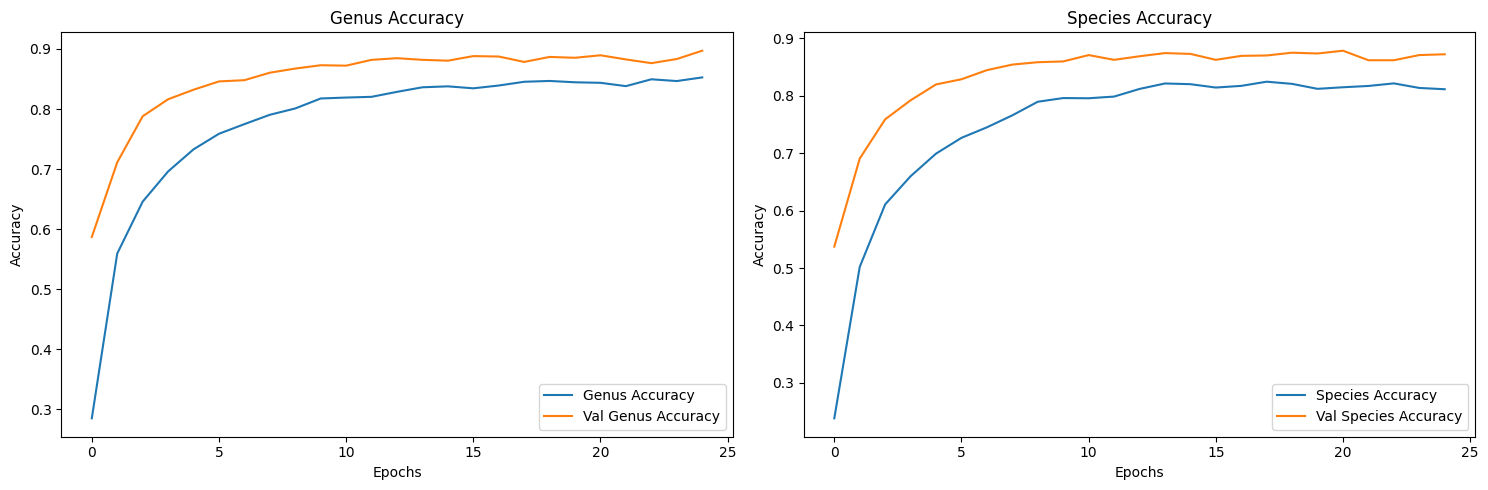

In [49]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['accuracy']#, 'AUC', 'Precision', 'Recall']
    
    for metric in metrics:
        # Plot for Genus
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history[f'genus_{metric}'], label=f'Genus {metric.capitalize()}')
        plt.plot(history.history[f'val_genus_{metric}'], label=f'Val Genus {metric.capitalize()}')
        plt.title(f'Genus {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

        # Plot for Species
        plt.subplot(1, 2, 2)
        plt.plot(history.history[f'species_{metric}'], label=f'Species {metric.capitalize()}')
        plt.plot(history.history[f'val_species_{metric}'], label=f'Val Species {metric.capitalize()}')
        plt.title(f'Species {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Assuming you have trained your model and stored the history
plot_training_history(history)

In [50]:
# Evaluate the model on the test dataset
prediction_metrics = model.evaluate(test_ds)

# Print out the accuracy for genus and species
print(f"Test Genus Accuracy: {prediction_metrics[1]:.4f}")
print(f"Test Species Accuracy: {prediction_metrics[2]:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - genus_accuracy: 0.8965 - loss: 6.8216 - species_accuracy: 0.8695
Test Genus Accuracy: 0.8961
Test Species Accuracy: 0.8796


In [51]:
import tensorflow as tf
import numpy as np

def predict_image(image_path, model, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k genus and species from an image using a trained model.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict genus and species
    genus_preds, species_preds = model.predict(img)

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    return top_k_genus, top_k_species

# Example usage
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Pseudochromidae_Cypho_purpurascens/52551_web_Cypho_purpurascens_151.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/70108_web_Eviota_melasma_52.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/fish_photo_1050.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_stictus/94362_web_Ecsenius_stictus_8.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Gobiodon_quinquestrigatus/59583_web_Gobiodon_quinquestrigatus_56.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_13.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Tripterygiidae_Enneapterygius_tutuilae/web_Enneapterygius_tutuilae_3.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_pulcher/fish_photo_17597.jpeg'
top_k_genus, top_k_species = predict_image(image_path, model, genus_labels, species_labels, top_k=3)

print("Top 3 Genus Predictions:")
for genus, confidence in top_k_genus:
    print(f"{genus}: {confidence:.4f}")

print("\nTop 3 Species Predictions:")
for species, confidence in top_k_species:
    print(f"{species}: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Top 3 Genus Predictions:
b'Ecsenius': 0.9755
b'Cirripectes': 0.0113
b'Eviota': 0.0056

Top 3 Species Predictions:
b'Ecsenius pulcher': 0.9990
b'Ostorhinchus angustatus': 0.0006
b'Cirripectes variolosus': 0.0002


In [18]:
def check_class_distribution(dataset, genus_labels, species_labels):
    genus_counts = {label: 0 for label in genus_labels}
    species_counts = {label: 0 for label in species_labels}

    for images, labels in dataset:
        genus_label_indices = tf.argmax(labels['genus'], axis=1).numpy()
        species_label_indices = tf.argmax(labels['species'], axis=1).numpy()

        for genus_idx, species_idx in zip(genus_label_indices, species_label_indices):
            genus_counts[genus_labels[genus_idx]] += 1
            species_counts[species_labels[species_idx]] += 1

    print("Genus Class Distribution:")
    for label, count in genus_counts.items():
        print(f"{label}: {count}")

    print("\nSpecies Class Distribution:")
    for label, count in species_counts.items():
        print(f"{label}: {count}")

# Check the training dataset
check_class_distribution(train_ds, genus_labels, species_labels)

# Check the validation dataset
#check_class_distribution(valid_ds, genus_labels, species_labels)

Genus Class Distribution:
b'Acanthemblemaria': 55
b'Aioliops': 49
b'Apogon': 210
b'Canthigaster': 322
b'Caracanthus': 127
b'Centropyge': 116
b'Chaetodon': 223
b'Chromis': 246
b'Cirripectes': 69
b'Corythoichthys': 254
b'Cypho': 106
b'Doryrhamphus': 116
b'Ecsenius': 108
b'Enchelyurus': 37
b'Enneanectes': 46
b'Enneapterygius': 151
b'Eques': 35
b'Eviota': 212
b'Fowleria': 43
b'Fusigobius': 138
b'Gobiodon': 146
b'Gomphosus': 70
b'Halichoeres': 82
b'Helcogramma': 42
b'Istigobius': 276
b'Koumansetta': 160
b'Labroides': 136
b'Limnichthys': 34
b'Nemateleotris': 425
b'Neocirrhites': 86
b'Ostorhinchus': 155
b'Paracirrhites': 69
b'Paragobiodon': 98
b'Plesiops': 59
b'Pleurosicya': 35
b'Pomacanthus': 250
b'Pomacentrus': 228
b'Priolepis': 75
b'Pristiapogon': 79
b'Pseudocheilinus': 322
b'Pseudogramma': 73
b'Scorpaenodes': 40
b'Sebastapistes': 60
b'Trimma': 48
b'Ucla': 78

Species Class Distribution:
b'Acanthemblemaria aspera': 55
b'Aioliops megastigma': 49
b'Apogon binotatus': 82
b'Apogon maculatus': 

2024-08-09 16:40:17.291760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
